# Classification

## 1. Data

The dataset for this lecture was prepared by the MoleculeNet group [WRF+18]. It is a collection of molecules that succeeded or failed in clinical trials.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
import numpy as np
import jax.numpy as jnp
import mordred, mordred.descriptors
import jax

In [2]:
# from zipfile import ZipFile
# from io import BytesIO
# from urllib.request import urlopen

# from web version
# url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz'
# file = urlopen(url).read()
# file = BytesIO(file)
# document = ZipFile(file)
# toxdata = pd.read_csv(document.open('clintox.csv'))

# local version
toxdata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz"
)
toxdata.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


## 2. Molecular Descriptors

This time, our data does not come with pre-computed descriptors. We only have the SMILES string, which is a way of writing a molecule using letters and numbers (a string). We can use rdkit to convert the SMILES string into a molecule, and then we can use a package called Mordred to compute a set of descriptors for each molecule. This package will compute around 1500 descriptors for each molecule.

We’ll start by converting our molecules into rdkit objects and building a calculator to compute the descriptors.

[09:54:11] Explicit valence for atom # 0 N, 5, is greater than permitted
[09:54:11] Can't kekulize mol.  Unkekulized atoms: 9
[09:54:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[09:54:11] Explicit valence for atom # 10 N, 4, is greater than permitted
[09:54:11] Can't kekulize mol.  Unkekulized atoms: 4
[09:54:11] Can't kekulize mol.  Unkekulized atoms: 4


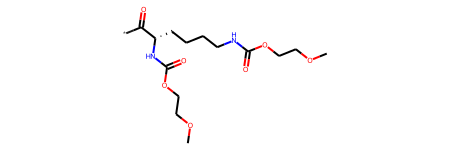

In [3]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# view one molecule to make sure things look good.
molecules[0]

Some of our molecules failed to be converted. We’ll have to remove them. We need to remember which ones were deleted too, since we need to remove the failed molecules from the labels.

In [4]:
# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

# Get the features from the mordred calculator
features = calc.pandas(valid_mols)

/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/eloisanchez/.local/lib/python3.10/site-packa

Now we just need to stich everything back together so that our labels are consistent and standardize our features.

In [5]:
labels = toxdata[valid_mol_idx].FDA_APPROVED
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features.dropna(inplace=True, axis=1)

print(f"We have {len(features.columns)} features per molecule")

/tmp/ipykernel_8538/2238410431.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features -= features.mean()


We have 483 features per molecule


## 3. Classification Models

### 3.1. Linear Perceptron

We can use regression. Basically if $\vec{w}·\vec{x}+b>0$ then $\hat{f}(\vec{x})=1$ and $\hat{f}(\vec{x})=0$ otherwise.

This model is called **perceptron** and is the first neuran network for classification. It is an example of a **hard** classifier, as it does not predict the probability of the class, it just predicts exactly one class.

The distance of $\vec{w}·\vec{x}+b$ from 0 is called the **decision boundary**.

In [6]:
def perceptron(x, w, b):
    v = jnp.dot(x, w) + b
    y = jnp.where(v > 0, x=jnp.zeros_like(v), y=jnp.ones_like(v))
    return y

Now that we have a model, we must choose a loss function. We haven’t learned about many loss functions yet. We’ve only seen mean squared error. Let us begin with a related loss called mean absolute error (MAE). MAE measures disagreement between our class and the predicted class. This is like an accuracy – what percentage of the time we’re correct.
$$
L=\frac{1}{N}\sum_i{|y_i-\hat{y}_i|}
$$

In [7]:
def loss(y, yhat):
    return jnp.mean(jnp.abs(y - yhat))


def loss_wrapper(w, b, x, y):
    yhat = perceptron(x, w, b)
    return loss(y, yhat)


loss_grad = jax.grad(loss_wrapper, (0, 1))

Now create the training and testing sets

In [8]:
batch_size = 32
train_N = int(len(labels) * 0.8)  # 80% for training and 20% for testing


N = len(labels)
batch_idx = range(0, train_N, batch_size)

# Random initialization of the parameters
w = np.random.normal(size=len(features.columns))
b = 0.0

# Create the function to calculate the gradient
loss_grad = jax.grad(loss_wrapper, (0, 1))

# Get the testing datasets
test_x = features[train_N:].values.astype(np.float32)
test_y = labels[train_N:].values

print(test_x.shape, test_y.shape)

(296, 483) (296,)


Let’s now try out our gradient to make sure it works

In [14]:
loss_grad(w, b, test_x, test_y)

(DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 

It’s all zeros! Why is that? It’s because our `jnp.where` statement above is not differentiable, nor are any inequalities where the result is a constant (1 or 0 in our case). The perceptron actually has a special training procedure that is not related to its derivatives. One of the motivating reasons that deep learning is popular is that we do not need to construct a special training process for each model we construct – like the training procedure for the perceptron.

### 3.2 Logistic Regression

Rather than teach and discuss the special perceptron training procedure, we’ll move to a more modern related classifier called a softmax binary classifier. This is a tiny change, the softmax binary classifier is:
$$
\hat{f}(\vec{x}) = \sigma(\vec{w}·\vec{x}+b)
$$

The input to the sigmoid can be viewed as log-odds, called logits for short. Odds are ratios of probability – odds of 1 means the probability of the class 1 is 0.5 and class 0 is 0.5. Odds of 2 means the probability of class 1 is 0.67 and class 0 is 0.33. Log-odds is the natural logarithm of that, so that log-odds of 0 means the odds are 1 and the output probability should be 0.5. One definition of the sigmoid is
$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

This type of binary classifier is sometimes called logistic regression because we’re regressing logits.

In essence, all we’ve done is replacing the inequality of the perceptron with a smooth differentiable version. Just like previously, a positive number indicated class 1 (FDA approved) but now it’s a continuum of numbers from 0.5 to 1.0. This is **soft** classification – we give probabilities of class membership instead of hard assignment. However, our loss function now needs to be modified as well.

There is a different loss function that works better with classification called **cross-entropy**. Cross-entropy is a loss function that describes distance between two probability distributions. When minimized, the two probability distributions are identical.

How is comparing predicted values $\hat{y}$ and $y$ like comparing two probability distributions? Even though these are both 1s and 0s in the case of hard classification, they do sum to 1, and so we consider them probability distributions. Cross-entropy is defined as:
$$
L=-\sum_c^K{y_c \log{\hat{y}_c}}
$$

Where $c$ indicates the class considered and it's assumed that $\sum_c^K y_c=1$ and $\sum_c^K \hat{y}_c=1$ like probabilities. When we have a binary classification $y_1 = 1 - y_0$ is also fulfilled and the loss function becomes
$$
L=-[y_0 \log{\hat{y}_0}+(1-y_0)\log{(1-\hat{y}_0})]
$$

Now we can create a batched gradient descent algorithm to train the classifier. Note, one change we need to do is use the built-in jax jax.nn.sigmoid function to avoid numerical instabilities and also add a small number to all logs to avoid numerical instabilities.

In [15]:
def bin_classifier(x, w, b):
    v = jnp.dot(x, w) + b
    return jax.nn.sigmoid(v)


def cross_ent(y, yhat):
    # Note that we add 1e-10 to the args of the logs to avoid numerical instability
    return jnp.mean(-(y * jnp.log(yhat + 1e-10) + (1 - y) * jnp.log(1 - yhat + 1e-10)))


def loss_wrapper(w, b, x, y):
    yhat = bin_classifier(x, w, b)
    return cross_ent(y, yhat)


loss_grad = jax.grad(loss_wrapper, (0, 1))

# Initialize random parameters
w = np.random.normal(scale=0.01, size=len(features.columns))
b = 1.0

# Check that the gradient function works
loss_grad(w, b, test_x, test_y)

(DeviceArray([ 1.75891537e-02,  1.82667524e-02, -3.72377522e-02,
               3.82295102e-02,  5.98209761e-02,  5.87680452e-02,
               5.59697917e-04,  1.07832756e-02,  5.33989221e-02,
               3.84421903e-03, -8.45261943e-03, -9.02092177e-03,
               8.19274783e-03,  1.91548262e-02,  3.28149647e-02,
              -3.18248831e-02, -5.43109737e-02, -1.20379347e-02,
               3.35625000e-02,  3.10756527e-02,  3.84263396e-02,
              -1.43378656e-02,  3.84790897e-02,  8.68054852e-03,
               2.88502537e-02,  1.91882420e-02,  2.16834676e-02,
               1.10510541e-02,  1.31059450e-03, -2.57580727e-03,
              -5.54740895e-03, -9.39316582e-03,  1.79300699e-02,
               1.82993151e-02,  2.21075341e-02,  1.80812143e-02,
               1.59600526e-02,  1.09306518e-02,  6.00710278e-03,
               1.28435437e-03, -2.23844801e-03, -2.48912983e-02,
              -1.63366832e-02,  7.33034080e-03,  9.55824088e-03,
              -3.33827618

Now we create the training loop

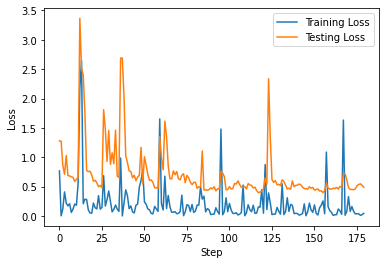

In [16]:
loss_progress = []
test_loss_progress = []
eta = 0.2
for epoch in range(5):
    for i in range(len(batch_idx) - 1):
        # 1. Get data of this batch
        x = features[batch_idx[i] : batch_idx[i + 1]].values.astype(np.float32)
        y = labels[batch_idx[i] : batch_idx[i + 1]].values
        # 2. Calculate gradient with this batch
        grad = loss_grad(w, b, x, y)
        # 3. Change the parameters in the direction of descending gradient
        w -= eta * grad[0]
        b -= eta * grad[1]
        # 4. Recalculate loss and save
        loss_progress.append(loss_wrapper(w, b, x, y))
        test_loss_progress.append(loss_wrapper(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.legend()
plt.ylabel("Loss")
plt.show()

## 4. Classification Metrics

In regression, we assessed model performance with a parity plot, correlation coefficient, or mean squared error. In classification, we use slightly different metrics. The first metric is **accuracy**. Accuracy is the percentage of time that the predicted label matches the true label. We do not have a hard classifier, so we have to choose how to turn probability into a specific class. For now, we will choose the class with the highest probability. Let’s see how this looks

In [18]:
def accuracy(y, yhat):
    # Conver from prob to hard class
    #? Why do we use the ones_like function and not 1
    hard_yhat = np.where(yhat > 0.5, np.ones_like(yhat), np.zeros_like(yhat))
    disagree = np.sum(np.abs(y-hard_yhat))
    return 1 - disagree / len(y)

accuracy(test_y, bin_classifier(test_x, w, b))

0.8648648648648649

An accuracy of 0.83 seems quite reasonable! However, consider this model:

In [19]:
def alt_classifier(x):
    return np.ones((x.shape[0]))


accuracy(test_y, alt_classifier(test_x))

0.9087837837837838

This model, which always returns 1, has better accuracy than our model. How is this possible?

If you examine the data, you’ll see the majority of the molecules passed FDA clinical trials ($y=1$), so that just guessing 1 is a good strategy.

### 4.1. Error Types

Let’s recall what we’re trying to do. We’re trying to predict if a molecule will make it through FDA clinical trials. Our model can be incorrect in two ways: it predicts a molecule will pass through clinical trials, but it actually fails. This is called a **false positive**. The other error is if we predict our drug will not make it through clinical trials, but it actually does. This is **false negative**.

Our `alt_classifier` model, which simply reports everything as positive, has no false negative errors. It has many false positive errors. These two types of errors can be quantified. We’re going to add one complexity – threshold. Although we train our model to minimize cross-entropy, we may want to be more conservative or aggressive in our classification with the trained model.

In [20]:
def error_types(y, yhat, threshold):
    hard_yhat = np.where(yhat >= threshold, np.ones_like(yhat), np.zeros_like(yhat))
    # predicted 1, actually was 0 -> 1 (bool to remove predicted 0, actually was 1)
    fp = np.sum((hard_yhat - y) > 0)
    # predicted 0, actually was 1 -> 1 (bool to remove predicted 1, actually was 0)
    fn = np.sum((y - hard_yhat) > 0)
    return fp, fn

In [21]:
print("Alt Classifier", error_types(test_y, alt_classifier(test_x), 0.5))
print("Trained Classifier", error_types(test_y, bin_classifier(test_x, w, b), 0.5))

Alt Classifier (27, 0)
Trained Classifier (20, 20)


We can see how increasing the threshold will minimize false positives at the cost of missing more possible aprovable molecules

In [22]:
print("Threshold 0.7", error_types(test_y, bin_classifier(test_x, w, b), 0.7))
print("Threshold 0.9", error_types(test_y, bin_classifier(test_x, w, b), 0.9))
print("Threshold 0.95", error_types(test_y, bin_classifier(test_x, w, b), 0.95))
print("Threshold 0.99", error_types(test_y, bin_classifier(test_x, w, b), 0.99))

Threshold 0.7 (16, 30)
Threshold 0.9 (10, 84)
Threshold 0.95 (7, 119)
Threshold 0.99 (0, 215)


In the last case we didn't obtain any false positive but we missed 215 possible molecules. Are we still obtainging some true positive molecules though?

In [23]:
total_pos = np.sum(test_y)
print(
    "Total positives:",
    total_pos,
    "Predicted Positives:",
    np.sum(bin_classifier(test_x, w, b) > 0.99),
)

Total positives: 269 Predicted Positives: 54


Yes, we are obtaining 54 molecules that will pass the FDA test while minimizing the false possitives a lot. We cannot do that with `alt_classifier`, since it only provides ones.

### 4.2. Receiver-Operating Characteristic Curve

